# AI4Mars

A Machine learning Model for Martian Terrain Image Segmentation

## Introduction

The objective of this project is to take the amazing work done by NASA and train a machine learning model on their [AI4Mars](https://data.nasa.gov/Space-Science/AI4MARS-A-Dataset-for-Terrain-Aware-Autonomous-Dri/cykx-2qix/about_data) dataset. This dataset is the culmination of an incredible effort by experts and the public at large to create a dataset for semantic segmentation of Martian terrain.

The AI4Mars dataset consists ~326K semantic segmentation full image labels on 35K images from Curiosity, Opportunity, and Spirit rovers, collected through crowdsourcing. Each image was labeled by 10 people to ensure greater quality and agreement of the crowdsourced labels. It also includes ~1.5K validation labels annotated by the rover planners and scientists from NASA’s MSL (Mars Science Laboratory) mission, which operates the Curiosity rover, and MER (Mars Exploration Rovers) mission, which operated the Spirit and Opportunity rovers.

As opposed to Earthly applications, training machine learning models for deep space missions is incredibly difficult. This is largely due to the scarcity of available training data and the stringent requirements for safety-critical flight software. As such, this project aims to train a machine learning model under the constraints imposed by a typical deep space mission. This means that efficiency in the size and resource utilization of a machine learning model will be considered a requirement. Thus, the goal of this project is not to train a state-of-the-art model, but rather train a model that meets the requirements.

For spacecraft flight software, a couple of general rules of thumb for
deploying math-intensive applications include:

1. The less math the better. Especially multiplication. 
2. Beware of division by zero. Protect against it at _all_ costs!

## Requirements

| ID          | Description                                                                         | Rationale                                                         | Verification Method |
|-------------|-------------------------------------------------------------------------------------|-------------------------------------------------------------------|---------------------|
| AI4MARS-001 | A machine learning model shall be trained on the AI4Mars v0.1 dataset                    | The AI4Mars dataset is robust and high quality.                   | Inspection          |
| AI4MARS-002 | A machine learning model shall perform semantic segmentation of Mars terrain imagery with an mIOU of at least 0.6| The task of the machine learning model is segmentation.           | Testing             |
| AI4MARS-003 | A machine learning model shall execute in under 1GB of RAM                          | The allocated RAM budget for the machine learning model is 1GB.   | Inspection          |
| AI4MARS-004 | A machine learning model shall fit in under 200MB of disk storage                     | The allocated disk budget for the machine learning model is 200MB.  | Inspection          |

## Setup

Lets start with setting up our notebook. We'll need to import our dependencies.

In [1]:
# Import all the modules we will need
from fastai.imports import *
from fastai.vision.all import *

from utils.utils import *
import PIL

# ! We need this to get some of the training output to work. This will be fixed
# in a future release of Jupyter for VS Code.
# https://github.com/microsoft/vscode-jupyter/pull/13442#issuecomment-1541584881
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


os.environ["ENABLE_WANDB"] = "ON"

if os.getenv("ENABLE_WANDB"):
    g_ENABLE_WANDB = True
    os.environ["WANDB_NOTEBOOK_NAME"] = "ai4mars.ipynb"
    import wandb
    from fastai.callback.wandb import *

    wandb.login()
    wandb.init(project="AI4Mars")
else:
    g_ENABLE_WANDB = False

DisplayHandle.update = update_patch

g_DEVICE = enable_gpu_if_available()
cleanup_gpu_cache()

wandb: Currently logged in as: astroesteban. Use `wandb login --relogin` to force relogin


__CUDA VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX A2000 8GB Laptop GPU
__CUDA Device Total Memory [GB]: 8.58947584


## Exploratory Data Analysis

### Download the Data

Now that we have all of our packages imported and our notebook set up, we can
proceed with downloading our data from Kaggle. 

Note that the data is available directly from NASA, a user-uploaded version to Kaggle makes downloading that data much easier.

In [2]:
dataset_path = download_ai4mars_dataset()

Setup the paths to our images and labels.

In [3]:
IMAGES_PATH = Path(dataset_path / "msl" / "images" / "edr")
MASK_PATH_TRAIN = Path(dataset_path / "msl" / "labels" / "train")
MASK_PATH_TEST = Path(
    dataset_path / "msl" / "labels" / "test" / "masked-gold-min3-100agree"
)

len(IMAGES_PATH.ls()), len(MASK_PATH_TRAIN.ls()), len(MASK_PATH_TEST.ls())

(6, 16064, 322)

In the dataset, the training and testing images are all thrown into one folder. There are also some images that are unlabled. 
For those images we have two options:

1. Toss them out
2. Create labels for them

For this project we will toss them out just for the sake of simplicity. Note that in deep learning you very rarely want to toss out data.

Lets set up the dataset.

In [4]:
IMAGES_PATH_TRAIN, IMAGES_PATH_TEST, IMAGES_PATH_UNUSED = prepare_dataset(
    IMAGES_PATH, MASK_PATH_TRAIN, MASK_PATH_TEST
)

In [5]:
assert len(IMAGES_PATH_TRAIN.ls()) == len(MASK_PATH_TRAIN.ls())

### Visualize an Image

Now that we have the data downloaded, we can proceed with actually visualizing some of the images and masks that we have.

Lets start by first seeing what one of these images looks like.

<Axes: >

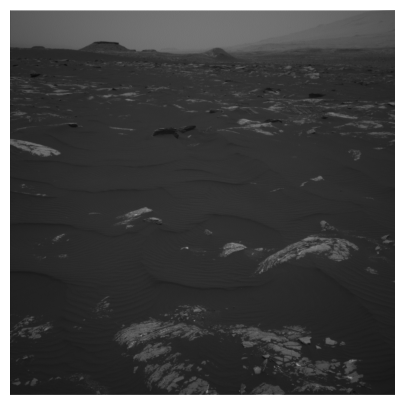

In [6]:
img = PILImage.create(IMAGES_PATH_TRAIN.ls()[2])
img.show(figsize=(5, 5))

### Visualize a Mask

Next, to see the corresponding mask associated with our image, we'll need a small function to help us map them on
the fly. According to the AI4Mars info.txt file, the images end with extension `.JPG` while the corresponding label
ends with `.png`.

In [7]:
get_mask_path = lambda file: MASK_PATH_TRAIN / f"{file.stem}.png"

<Axes: >

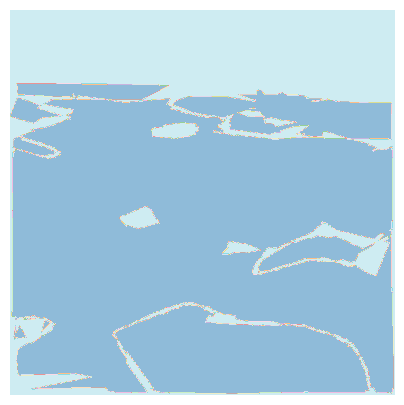

In [8]:
example_mask = PILMask.create(get_mask_path(IMAGES_PATH_TRAIN.ls()[2]))
example_mask.show()

### Data Engineering

In semantic segmentation, the “labels” are a 1:1 mask of the original picture with each pixel representing a label and are single channel:

In [9]:
tensor(example_mask)

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]], dtype=torch.uint8)

Very quickly we see an issue!

Because of how the loss gets calculated (and how fastai does things in general), the values of the pixel mask must be from 0 -> n, with n being the number of classes possible. If we take things as they are here during training you’ll hit an error that says “CUDA Segmentation Fault, Index Out of Bounds” (or something similar).

This is because our labels should be from 0 -> 4, to align with the fact predicted probabilities from our model are 0 -> 4. Instead they are 0, 1, 2, 3 and 255, leading to this issue.

So how do we fix the issue? In numpy we can just override the numbers for a particular value in the array and set it. To generalize this however a dictionary of the original value to the new one should also be made:

In [10]:
unique_codes = {0: 0, 1: 1, 2: 2, 3: 3, 4: 255}

Next we need to create a get_y function. In this case it should take in a filename and our dictionary, open the filename, and return the mask:

In [11]:
def get_label(filename: Path, unique_codes: dict) -> PILMask:
    filename = get_mask_path(filename)
    mask_array = np.asarray(PIL.Image.open(filename)).copy()

    mask_array[mask_array == 255] = 4

    return PILMask.create(mask_array)

Lets stop check this now.

In [12]:
tensor(get_label(IMAGES_PATH_TRAIN.ls()[2], unique_codes))

tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]], dtype=torch.uint8)

<Axes: >

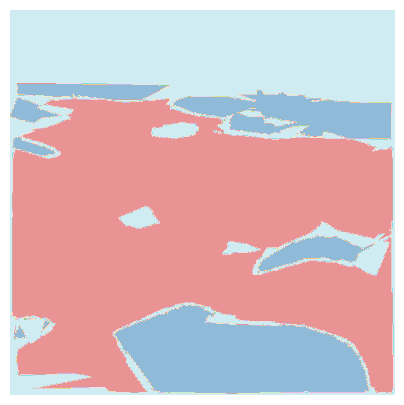

In [13]:
mask: PILMask = get_label(IMAGES_PATH_TRAIN.ls()[2], unique_codes)
mask.show()

Perfect!

The next thing we should do is create a list of our codes that map to the corresponding pixel value. According to the
info.txt, the codes are as follows:

| RGB         | Key             |
|-------------|-----------------|
| 0,0,0       | soil            |
| 1,1,1       | bedrock         |
| 2,2,2       | sand            |
| 3,3,3       | big rock        |
| 255,255,255 -> 4, 4, 4 | NULL (no label) |

In [14]:
codes = np.array(["soil", "bedrock", "sand", "big rock", "null"], dtype=str)

## Create Our `DataLoader`

Now everything is in place to create our `DataBlock` object. Jeremy Howard, the founder of Fast.AI, popularized the idea of image resizing:

* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

In the AI4Mars paper, the authors mention that they resize their images to 512x512 from the original 1024x1024 size.

Since I am training on a laptop GPU, I will resize the images to 256x256.

In [15]:
mask_sizes = mask.shape
mask_sizes

(1024, 1024)

In [16]:
mask_sizes = tuple(int(x / 4) for x in mask_sizes)
mask_sizes

(256, 256)

In the AI4Mars paper, the authors mention that the "batch size was chosen to be as large as possible before running into GPU memory issues". We will do the same.

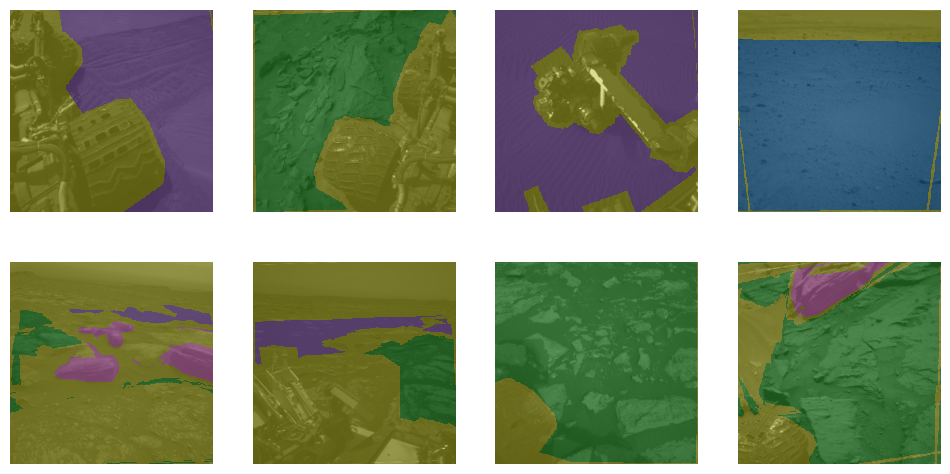

In [17]:
data_loader = DataBlock(
    blocks=(
        ImageBlock,
        MaskBlock(codes=codes),
    ),  # our input is an image and outpus is a mask
    splitter=RandomSplitter(),  # randomly split our dataset into 80% train and 20% valid
    get_y=partial(get_label, unique_codes=unique_codes),  # load our preprocessed labels
    batch_tfms=[
        *aug_transforms(size=mask_sizes),
        Normalize.from_stats(*imagenet_stats),
    ],  # apply some standard augs
).dataloaders(get_image_files(IMAGES_PATH_TRAIN), bs=8)

data_loader.show_batch()

## Select Our Model Architecture

Next, we can create our `Learner` object that will wrap our model architecture, hyperparameters, and `DataLoader` into one abstract object.

In the AI4Mars paper, the authors opted for the DeepLabv3+ model architecture with a ResNet-101 backend pretrained on ImageNet. For our architecture, we will go with a U-Net with a ResNet-34 backing that's been pre-trained on ImageNet. We _could_ utilize a fancy modern vision transformer, however, with spacecraft you want technology that is tried and true. U-Net has a long and rich history that make it a reliable model architecture for our purposes.

![U-Net Diagram](./../img/u_net_arch.png "U-Net Architecture Diagram")

Now lets define our U-Net architecture with the ResNet-18 backbone. The metrics
we use are the accuracy and mIoU. Our loss function is the CrossEntropyLoss.
The optimizer is good ol' Adam.

In [18]:
cleanup_gpu_cache()

learner = unet_learner(
    data_loader,
    resnet34,
    metrics=[partial(foreground_acc, bkg_idx=4), JaccardCoeffMulti()],
    loss_func=CrossEntropyLossFlat(axis=1),
    opt_func=Adam,
    norm_type=None,
    wd_bn_bias=True,
)

This is what our model architecture looks like.

In [19]:
learner.summary()

DynamicUnet (Input shape: 8 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

As per our requirements, our model **must** fit under the imposed limit. Lets check and make sure we are meeting our requirement.

In [20]:
assert calc_model_size(learner.model) <= 200.0

model size: 157.320MB


## Train

The first thing we want to do before we train our model is find a good learning rate.

'Learning Rate: 9.120108734350652e-05'

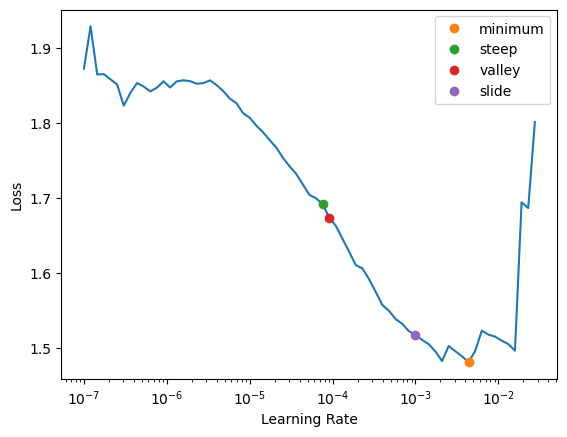

In [21]:
learning_rates = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

learner.lr = learning_rates.valley

f"Learning Rate: {learner.lr}"

Great! Lets now freeze our model. What freezing does is that it prevents layers of our model from changing
throughout the training process. This is very useful when we already have a pre-trained model whose existing
knowledge we don't want to lose. With freezing we freeze the layers from top down and the final layers are
free to learn the new segmentation task.

In [22]:
# Lets freeze the top layers so that we don't lose some of the pre-trained
# knowledge
learner.freeze()

In [23]:
# Set some callbacks for our model. One important callback is "early stopping"
# which is a simple regularization technique we can use to stop training when
# a specific metric, in this case the validation loss, stops improving.

# TODO: Have SaveModelCallback use safetensor instead of unsafe pickle format
callbacks: List[Callable] = [
    ShowGraphCallback(),
    EarlyStoppingCallback(),
    SaveModelCallback(fname="/workspace/models/ai4mars_model"),
]

if g_ENABLE_WANDB:
    callbacks.append(WandbCallback()) 

Finally, now we can train our model.

In [ ]:
cleanup_gpu_cache()

learner.fit_one_cycle(20, cbs=callbacks)

cleanup_gpu_cache()

Lets save the model to disk. Since we won’t be training the model further, we
can ignore the optimizer and only save the model weights.

In [ ]:
learner.save("/workspace/models/ai4mars_model", with_opt=False)

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
learner.recorder.plot_sched()

## Evaluate

In [ ]:
learner.show_results(max_n=4)

In [ ]:
interpreter = SegmentationInterpretation.from_learner(learner)

In [ ]:
interpreter.plot_top_losses(4)

### Profile

In this section we want to profile our trained model to get a good feel for how
it will perform in the deployment environment.

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
# Read a PIL image 
import torchvision

image = PIL.Image.open(IMAGES_PATH_UNUSED.ls()[3])
# image = torchvision.transforms.functional.pil_to_tensor(image) / 255.0

In [ ]:
learner.to("cpu")

with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        learner.predict(IMAGES_PATH_UNUSED.ls()[3])

In [ ]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

## Conclusion and Future Work

We have sucessfully trained a model that meets all of our requirements. It
might not be the best and greatest but it works just fine under our constraints.

For some future work, I'd like to throw out some of these constraints and
explore what a state-of-the-art model would look like for this dataset. Perhaps
a transformer architecture? Additionally, it would be great to explore how to
use the data that was missing the labels. Perhaps we can manually label them,
although it will take some time and having an expert would be better. Or, we
could have a foundation model like SAM segment the image for us. Another
interesting avenue is to explore deployment optimization techniques like
quantization for efficient embedded device deployment.So many things to do! 

## References

[1] AI4MARS: A dataset for Terrain-Aware autonomous driving on Mars. (2021, June 1). IEEE Conference Publication | IEEE Xplore. https://ieeexplore.ieee.org/document/9523149.

[2] SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers. (2021, October 21). https://arxiv.org/abs/2105.15203v3.

[2] Mish: A Self Regularized Non-Monotonic Activation Function. (2019, August 13). https://arxiv.org/abs/1908.08681